# Generate Synthetic data with non-linear, coupled, contemporaneous relationships

In [49]:
import sys
sys.path.append("../../") # if running from this folder
from matplotlib import pyplot as plt
import torch
from src.data.synthetic_temporal_causal_graph import SyntheticTCG, generate_data
from src.eval import plot_all_contemporaneous_relationships
from IPython.display import SVG
from lingam.utils import make_dot
from src.utils import get_model_device

Settings

In [50]:
N = 4     # num nodes
E = 0     # num external nodes
K = 5    # max lags
T = 2000  # sequence length
milestones = [0, 400, 1000, 1300, 1700]  # start with cm1, change to cm2 at t=400, change back to cm1 at t=600

file_name = f"synthetic_contemporaneous_N-{N}_T-{T}_K-{K}"

Function for rendering the graph.

In [51]:
def render_graph(file_name, causal_graph):
    labels = [f"N{i}" for i in range(causal_graph.num_internal_nodes)] + [f"E{i}" for i in range(causal_graph.num_external_nodes)]
    dot_graph = make_dot(causal_graph.get_causal_matrix(), labels=labels)
    dot_graph.format = 'svg'
    dot_graph.render(file_name, cleanup=True)
    display(SVG(f'{file_name}.svg'))

In [52]:
def normalize_data(x):
    x = x - x.mean(dim=-1, keepdim=True)
    x = x / x.std(dim=-1, keepdim=True)
    return x

## Generate the causal graph structure
Iterate on this cell until you find a graph that you like. 

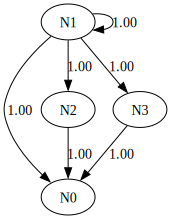

In [74]:
causal_graph_1 = SyntheticTCG(num_internal_nodes=N, max_lags=K, min_incoming_connections=1, num_external_nodes=E, num_ext_connections=1)
render_graph('causal_graph_1', causal_graph_1)

This function initializes the non-linear functions according to the graph by training them on random data points.

In [76]:
causal_graph_1.init_functional_relationships()

Training.. Loss=0.0618: 100%|█████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 254.09it/s]


Iterate until you find an altered causal graph you like.

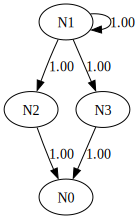

In [77]:
causal_graph_2 = causal_graph_1.permute_random_connection()
render_graph('causal_graph_2', causal_graph_2)

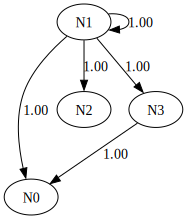

In [80]:
causal_graph_3 = causal_graph_1.permute_random_connection()
render_graph('causal_graph_3', causal_graph_3)

Generate synthetic data using the milestones provided. In this example, it starts with causal graph 1, changes to 2 and then changes back.

Generating temporal data..: 100%|████████████████████████████████████████████████| 2501/2501 [00:01<00:00, 1722.94it/s]


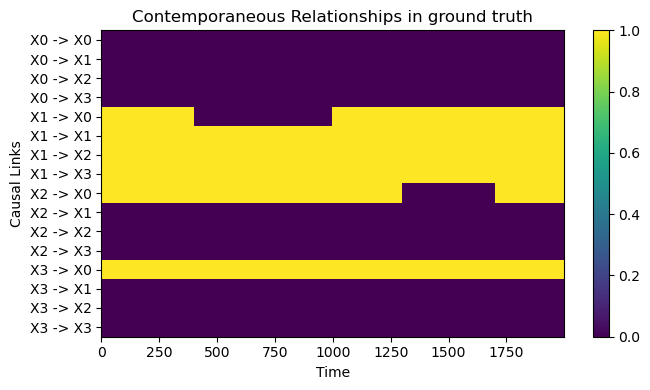

In [81]:
mile_stone_config = list(zip(milestones, [causal_graph_1, causal_graph_2, causal_graph_1, causal_graph_3, causal_graph_1]))
data, data_noise_adjusted, ground_truth = generate_data(mile_stone_config, sequence_length=T, warmup=500)

data = normalize_data(data)
data_noise_adjusted = normalize_data(data_noise_adjusted)
plot_all_contemporaneous_relationships(ground_truth[0], 'ground truth')
plt.show()

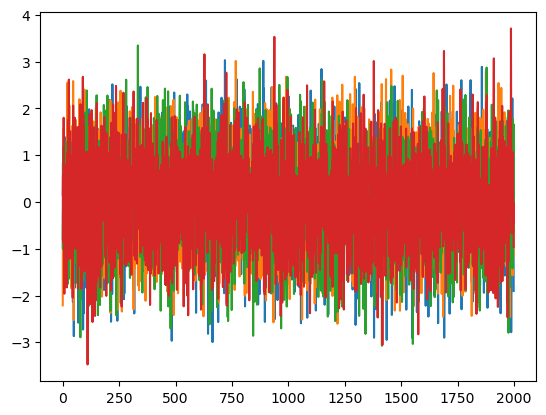

In [82]:
plt.plot(data[0, :, :].t())

The mean of the data is outputted as well and can be used to evaluate the correctness of the mu predictions in variational inference.

In [83]:
print("data               :", data.size())
print("data_noise_adjusted:", data_noise_adjusted.size())
print("ground_truth       :", ground_truth.size())

data               : torch.Size([1, 4, 2000])
data_noise_adjusted: torch.Size([1, 4, 2000])
ground_truth       : torch.Size([1, 4, 4, 2000])


Save the data to a file.

In [84]:
path = f"{file_name}.pt"
torch.save({'data': data, 'data_noise_adjusted': data_noise_adjusted, 'ground_truth': ground_truth}, path)
print(f"Written to '{path}'!")

Written to 'synthetic_contemporaneous_N-4_T-2000_K-5.pt'!


This is the part in the data where the two causal connections change.

In [ ]:
node_from, node_to = 0, 2
plt.plot(data[0, node_from, 250:350], label=f"Train data")
plt.plot(data_noise_adjusted[0, node_from, 250:350], label=f"Train data without noise (mean)")
plt.plot(ground_truth[0, 1, 3, 250:350], label=f"N1 causes N4")
plt.plot(ground_truth[0, 1, 0, 250:350], label=f"N0 causes N1")
plt.legend()